In [1]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import numpy as np
from functools import reduce

plt.style.use("seaborn")

# Produce data

To retrieve the raw data, the Python static code analyzer [Lizard](https://github.com/terryyin/lizard) was used.

```
# the following command produces a csv-file with all the necessary data for analysis
# stand in the root folder of inda student repos
# -o specifies output name
# --exclude excludes all files containing 'Test'
# --csv specifies format

lizard -o inda-repos-students.csv --exclude "^.*Test.*$" --csv -l java
```

# Process data
Next step is to process the generated data. The CSV-file has an verbose output string that contains all necessary information which can be retrieved by regex.

In [2]:
# specify input and output paths
source = "data/lizard/inda-repos-students.csv"
destination = "data/processed/inda-repos-students.csv"

# the source (Lizard) csv-header and the destination header
source_headers = ["NLOC", "CCN", "token", "PARAM", "length", "verbose", "input", "class::method", "class::method(args)", "start line", "end line"]
destination_headers = ["NLOC", "CCN", "token", "PARAM", "length", "TA", "student", "task", "class", "method"]

# necessary regex is stored in a dictionary
regex = {
    "task": "((?<=task-)[0-9]+)", # capture a number preceded by 'task-'
    "class": "^[A-Za-z0-9]*", # capture any letter or number from start to end of string
    "TA": "(?<=repos\/)[A-Za-z]+(?=\/)", # capture any string preceded by 'repos/' and ending with a '/'
    "student": "((?<=\/)([a-zA-Z0-9]+)(?=-task))", # capture any string preceded by '/' and ending with '-task'
    "method": "((?<=::).*(?=\())" # nasty
}

Next we process the data by extracting the right information from the Lizard file. At the end there's a report of the amount of faulty lines.

TODO: ta reda på vad som faktiskt orsakar `AttributeError`.

In [3]:
rows = []
attribute_errors = 0
with open(source, newline='') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=source_headers)
    for row in reader:
        try:
            ta = re.search(regex["TA"], row['verbose']).group(0)
            student = re.search(regex["student"], row['verbose']).group(0)
            task = int(re.search(regex["task"], row['verbose']).group(0))
            clss = re.search(regex["class"], row['class::method']).group(0)
            method = re.search(regex["method"], row['class::method(args)']).group(0)
        except AttributeError:
            # eftersom lösningar som ej kompilerar pajar regexen är detta nödvändigt
            # Sätter till NaN för att kunna filtrera ut i Pandas
            attribute_errors = attribute_errors + 1 # keep track of amount of faulty lines
            ta = "NaN"
            student = "NaN"
            task = "NaN"
            clss = "NaN"
            method = "NaN"
        new_row = { # if we reach here all is well
                    "NLOC": row['NLOC'], 
                    "CCN": row['CCN'], 
                    "token": row['token'], 
                    "PARAM": row['PARAM'], 
                    "length": row['length'],
                    "TA": ta,
                    "student": student, 
                    "task": task, 
                    "class": clss, 
                    "method": method
                    }
        rows.append(new_row)

with open(destination, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=destination_headers)
    writer.writeheader()
    writer.writerows(rows)

print(f"Done parsing a total of {len(rows)} rows, with {attribute_errors} faulty lines! That's a felmariginal of {attribute_errors/len(rows)}")


Done parsing a total of 12324 rows, with 23 faulty lines! That's a felmariginal of 0.001866277182732879


# Analyze inda code templates

Here the empty code templates are measured.

In [4]:
# Find Lines of Code for the code templates 
# Note that task 2-4 are empty, yet students recieve a Java template from Objects First

df_templates = pd.read_csv("data/processed/inda-templates-sorted.csv")
df_templates = df_templates.groupby(["task"])["NLOC"].sum().astype(float).reset_index()

# as there's no provided code skeleton for task 2-4, 10 and 17 these are manually appended
missing_tasks =  ({
            "task": [1, 2, 3, 4, 10, 17],
            "NLOC": [0, 0, 0, 0, 0, 0]
            })

# the missing tasks are concatenated, and then the dataframe is reindexed with task as index
df_templates = pd.concat([df_templates, pd.DataFrame(missing_tasks)], ignore_index = True, axis = 0)
df_templates = df_templates.sort_values(by=["task"]).reset_index(drop = True)
df_templates.head()


,task,NLOC
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,344.0


In [5]:
df_students = pd.read_csv("data/processed/inda-repos-students.csv")
df_students = df_students.groupby(["task", "student"])["NLOC"].sum().reset_index().astype({"task": int})
df_students = df_students.set_index(["task"])
df_students.head()

,student,NLOC
task,,
1,falkborn,3
2,alflil,16
2,birgerk,72
2,dlindbo,27
2,falkborn,66


/tmp/ipykernel_389/1991430965.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  dd1337 = df[df["task"].between(1, 9, inclusive=True)]
/tmp/ipykernel_389/1991430965.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  dd1338 = df[df["task"].between(10, 18, inclusive=True)]


,task,NLOC
count,236.000000,236.000000
mean,5.555085,277.529661
std,2.276881,209.781475
min,1.000000,3.000000
25%,4.000000,71.000000
50%,6.000000,223.000000
75%,8.000000,468.000000
max,9.000000,899.000000


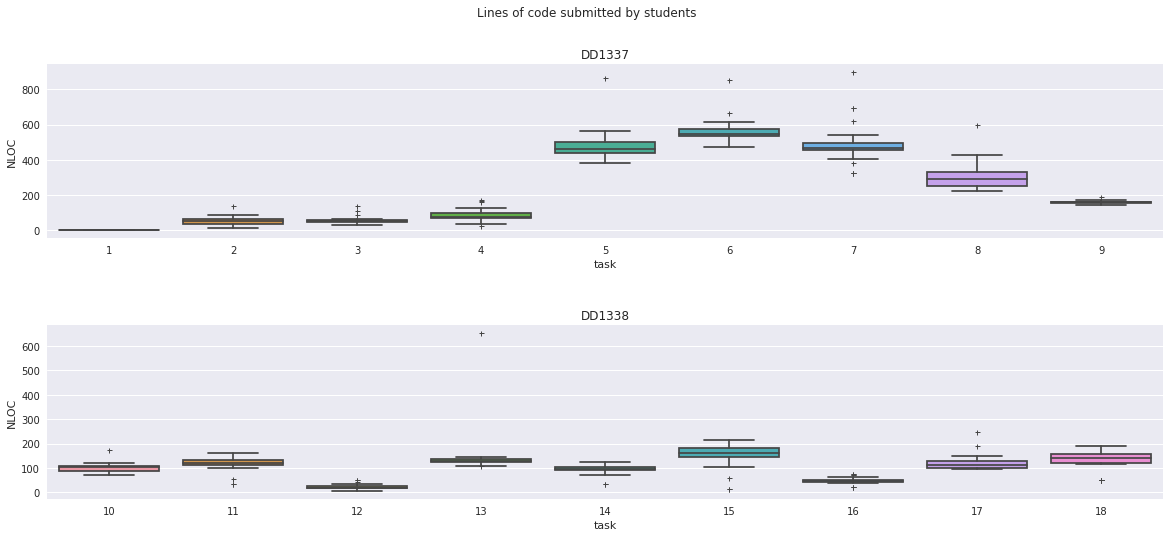

In [6]:
# SANDBOX

df =  df_students.groupby(["task", "student"])["NLOC"].sum().reset_index()

fig, axs = plt.subplots(2, 1,figsize=(20,8))
fig.suptitle("Lines of code submitted by students")

dd1337 = df[df["task"].between(1, 9, inclusive=True)]
dd1338 = df[df["task"].between(10, 18, inclusive=True)]

# axs[0].boxplot task 1-9
sn.boxplot(ax = axs[0], x="task", y = "NLOC", data = dd1337, flierprops = {"marker": "+", "color": "red"})
axs[0].set_title("DD1337")

sn.boxplot(ax = axs[1], x="task", y = "NLOC", data = dd1338, flierprops = {"marker": "+", "color": "red"})
axs[1].set_title("DD1338")

plt.subplots_adjust(hspace=0.5)

dd1337.describe()

/tmp/ipykernel_389/2270123388.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 25, markersize = 1.5, alpha = 0.8)


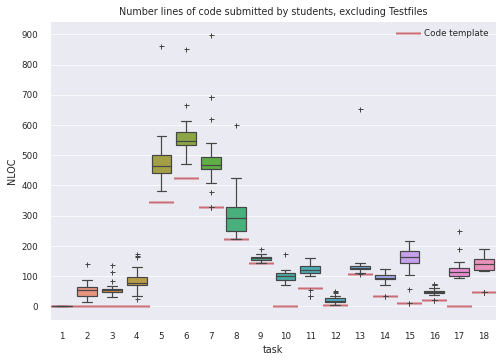

In [7]:
# Plot lines of code for students submissions and code template
sn.set_theme()
sn.set_context("paper")

# TODO: kan jag använda subplots för att DD1337 och DD1338?
df =  df_students.groupby(["task", "student"])["NLOC"].sum().reset_index()
df["task"] = df["task"].astype("int")

# plot templates as a horizontal line
plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 25, markersize = 1.5, alpha = 0.8)

# plot all tasks
ax = sn.boxplot(x="task", y = "NLOC", data = df, flierprops = {"marker": "+", "color": "red"})
ax.set_title("Number lines of code submitted by students, excluding Testfiles")
plt.yticks(np.arange(0, 1000, step=100))
plt.legend()

/tmp/ipykernel_389/311318454.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 17, markersize = 4)


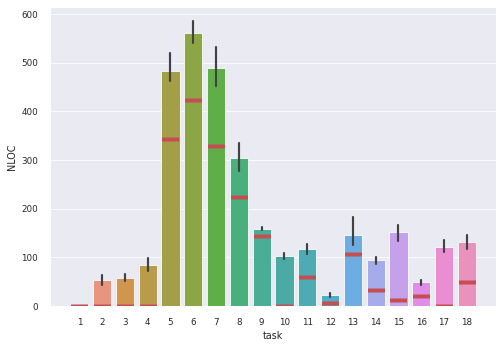

In [8]:
# Another variant of plot
ax = sn.barplot(x="task", y="NLOC", data=df)
plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 17, markersize = 4)

# Compose data

Experementing with other plot ideas and metrics.

In [9]:
# Read the data
df = pd.read_csv("data/inda-data-test-by-ta.csv")

In [10]:
# Group and sumarize
group = df.groupby(["TA", "student", "task", "class", "method"]).sum() # kan sätta set_index = False för att få en df
group.describe()

,NLOC,CCN,token,PARAM,length
count,7516.000000,7516.000000,7516.000000,7516.000000,7516.000000
mean,8.966605,2.259846,50.917908,0.808542,10.087946
std,7.346410,1.852495,52.650429,1.140292,9.183056
min,1.000000,1.000000,5.000000,0.000000,1.000000
25%,4.000000,1.000000,17.000000,0.000000,4.000000
50%,7.000000,2.000000,35.000000,1.000000,7.000000
75%,11.000000,3.000000,65.000000,1.000000,12.000000
max,102.000000,32.000000,748.000000,16.000000,137.000000


In [11]:
operations = df.groupby(["TA", "task", "student", "class"])["method"].count()
operations.head()

TA     task  student   class           
linus  2     alflil    Ticketmachine        4
             birgerk   TicketMachine       10
             dlindbo   TicketMachine        6
             falkborn  TicketMachine       11
             grin      TicketMachine244     5
Name: method, dtype: int64

In [12]:
nloc = df.groupby(["TA", "task", "student", "class"])["NLOC"].sum()
nloc.head()

TA     task  student   class           
linus  2     alflil    Ticketmachine       16
             birgerk   TicketMachine       72
             dlindbo   TicketMachine       27
             falkborn  TicketMachine       66
             grin      TicketMachine244    20
Name: NLOC, dtype: int64

In [13]:
# TODO kan jag helt sonika summera detta?
ccn = df.groupby(["TA", "task", "student", "class"])["CCN"].sum()
ccn.head()


TA     task  student   class           
linus  2     alflil    Ticketmachine        4
             birgerk   TicketMachine       12
             dlindbo   TicketMachine        6
             falkborn  TicketMachine       11
             grin      TicketMachine244     5
Name: CCN, dtype: int64

# Make plots

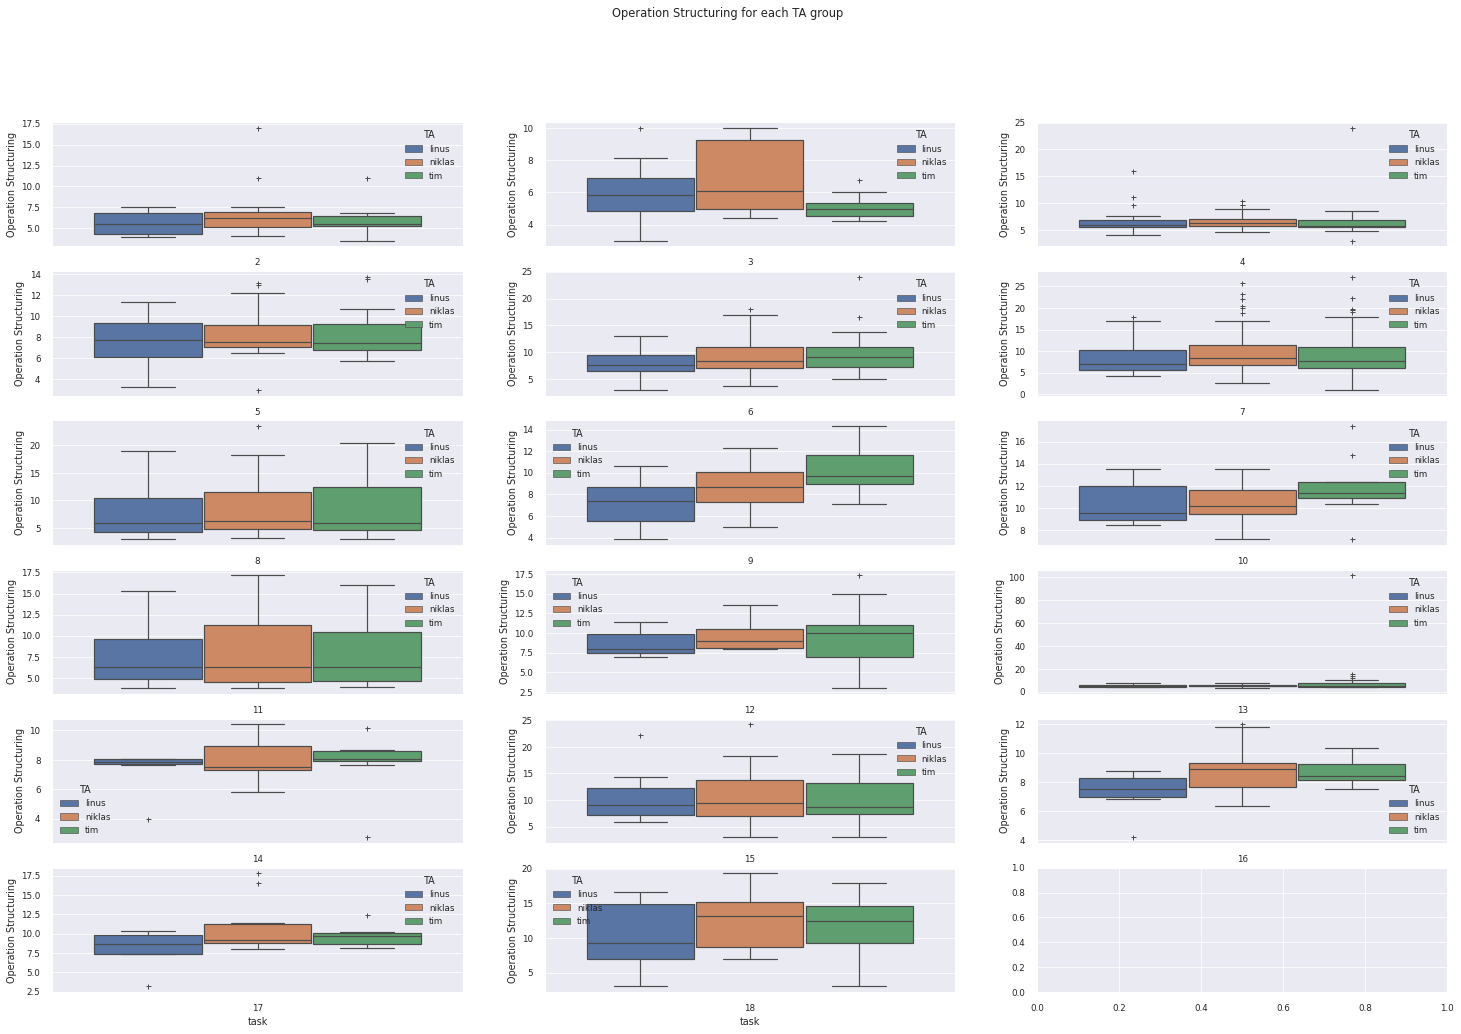

In [14]:
# TODO bör jag summera över alla klasser?
op_st = (nloc/operations).to_frame().reset_index().rename(columns={0: "Operation Structuring"})
op_st.head()

fig, axes = plt.subplots(6, 3, figsize = (25, 16))
fig.suptitle("Operation Structuring for each TA group")

# TODO hard coded...
k = 2
for i in range(0, 6):
    for j in range (0, 3):
        sn.boxplot(ax=axes[i,j], x="task", y = "Operation Structuring", 
            hue="TA",
            data = (op_st.loc[op_st["task"] == k]),
            flierprops = {"marker": "+"})
        # TODO dum workaround
        k = k + 1
        if k > 18:
            break
            


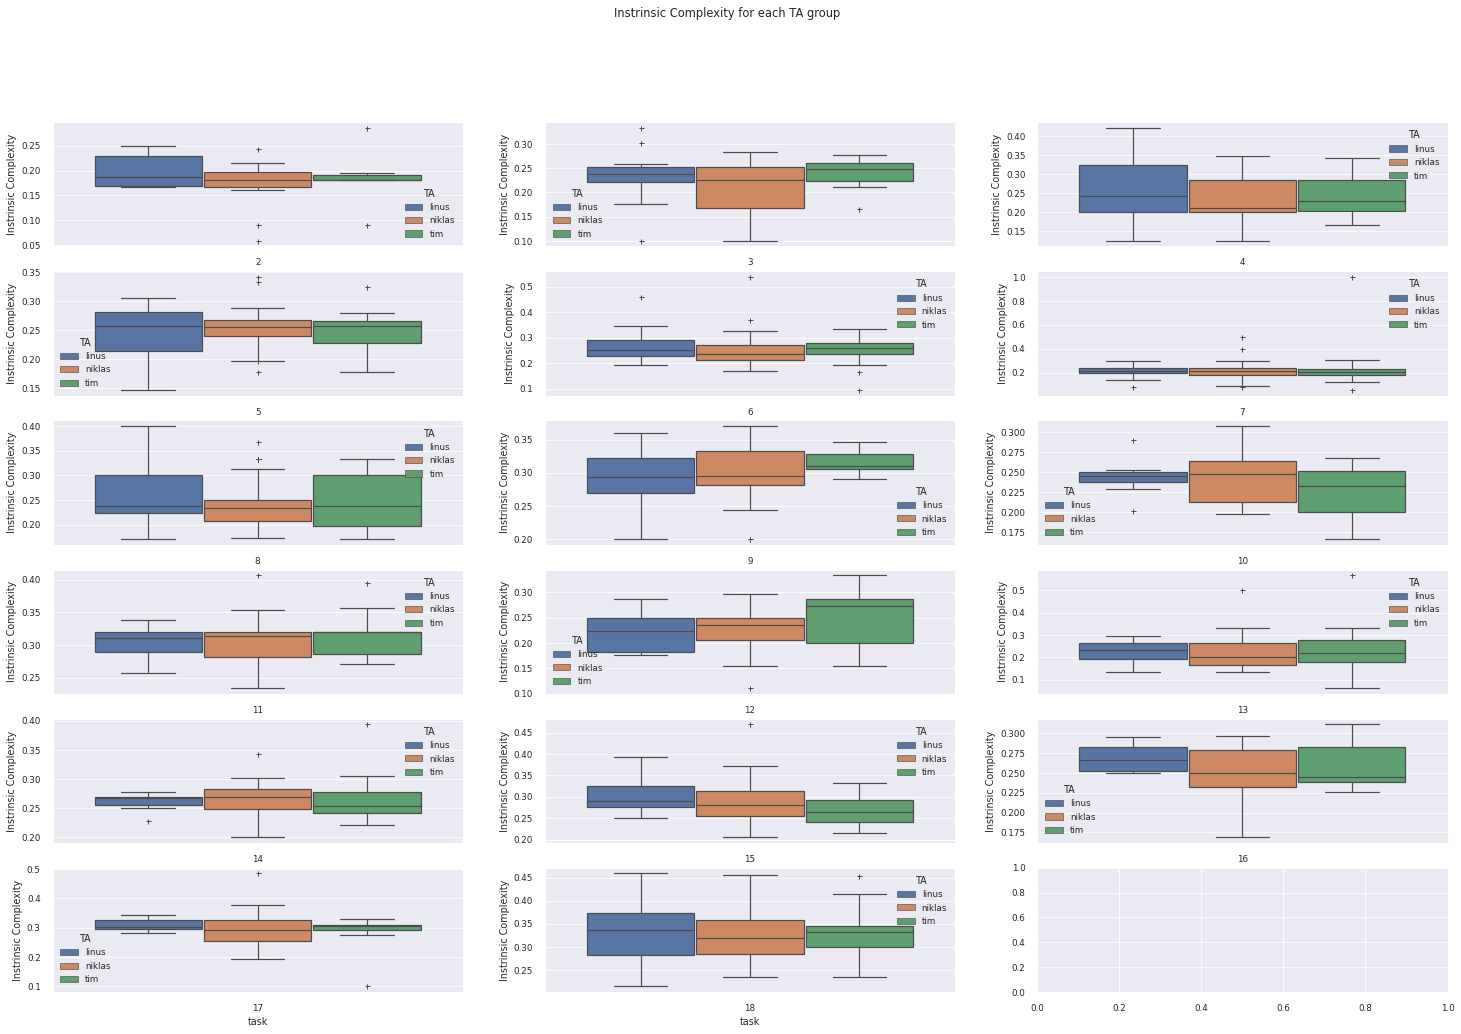

In [15]:
# TODO bör jag summera över alla klasser?
int_comp = (ccn/nloc).to_frame().reset_index().rename(columns={0: "Instrinsic Complexity"})
int_comp.head()

fig, axes = plt.subplots(6, 3, figsize = (25, 16))
fig.suptitle("Instrinsic Complexity for each TA group")

# TODO hard coded...
k = 2
for i in range(0, 6):
    for j in range (0, 3):
        sn.boxplot(ax=axes[i,j], x="task", y = "Instrinsic Complexity", 
            hue="TA",
            data = (int_comp.loc[int_comp["task"] == k]),
            flierprops = {"marker": "+"})
        # TODO dum workaround
        k = k + 1
        if k > 18:
            break
            

# Violations

['n: 16',
 'n: 13',
 'n: 11',
 'n: 13',
 'n: 13',
 'n: 13',
 'n: 13',
 'n: 10',
 'n: 14',
 'n: 14',
 'n: 15',
 'n: 13',
 'n: 14']

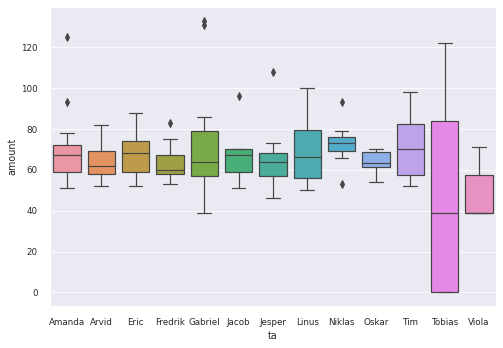

In [16]:
df = pd.read_csv("data/processed/student-violations-data.csv")
#df.groupby(["task", "ta", "student"])["has"].count()
df.head()

#for ta, data in df.groupby("ta"):
#    plt.plot(data["amount"], data["violation"])

violations = df.groupby(["task", "ta", "student"])["amount"].sum().to_frame().reset_index()


students = df.groupby(["task", "ta"])["student"].nunique().to_frame().reset_index()



d1 = violations.loc[violations["task"] == 5]

"""
ax = sn.barplot(x = "ta", y = "count", data = d1)
ax.bar_label(ax.containers[0], labels = d2["student"])
"""

ax = sn.boxplot(x = "ta", y = "amount", data = d1)
#ax = sn.stripplot(x = "ta", y = "amount", data = d1, color = ".3", alpha = 0.8)

nobs = students.loc[students["task"] == 5]
nobs = nobs["student"]
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
nobs

In [17]:
# SANDBOX PLAYGROUND ET C 
# Anynomize data
df = pd.read_csv("data/processed/student-violations-data.csv")
names = ["Bob", "Jane", "Kim", "Ada", "Jen", "Mia", "Rob", "Ali", "Pia", "Per", "Carl", "Bert", "Alf", "Ann", "May"] 

i = 0
for name, row in df.groupby(["ta"]):
    df = df.replace({str(name): names[i]},regex=True)
    i = i + 1


/home/vscode/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


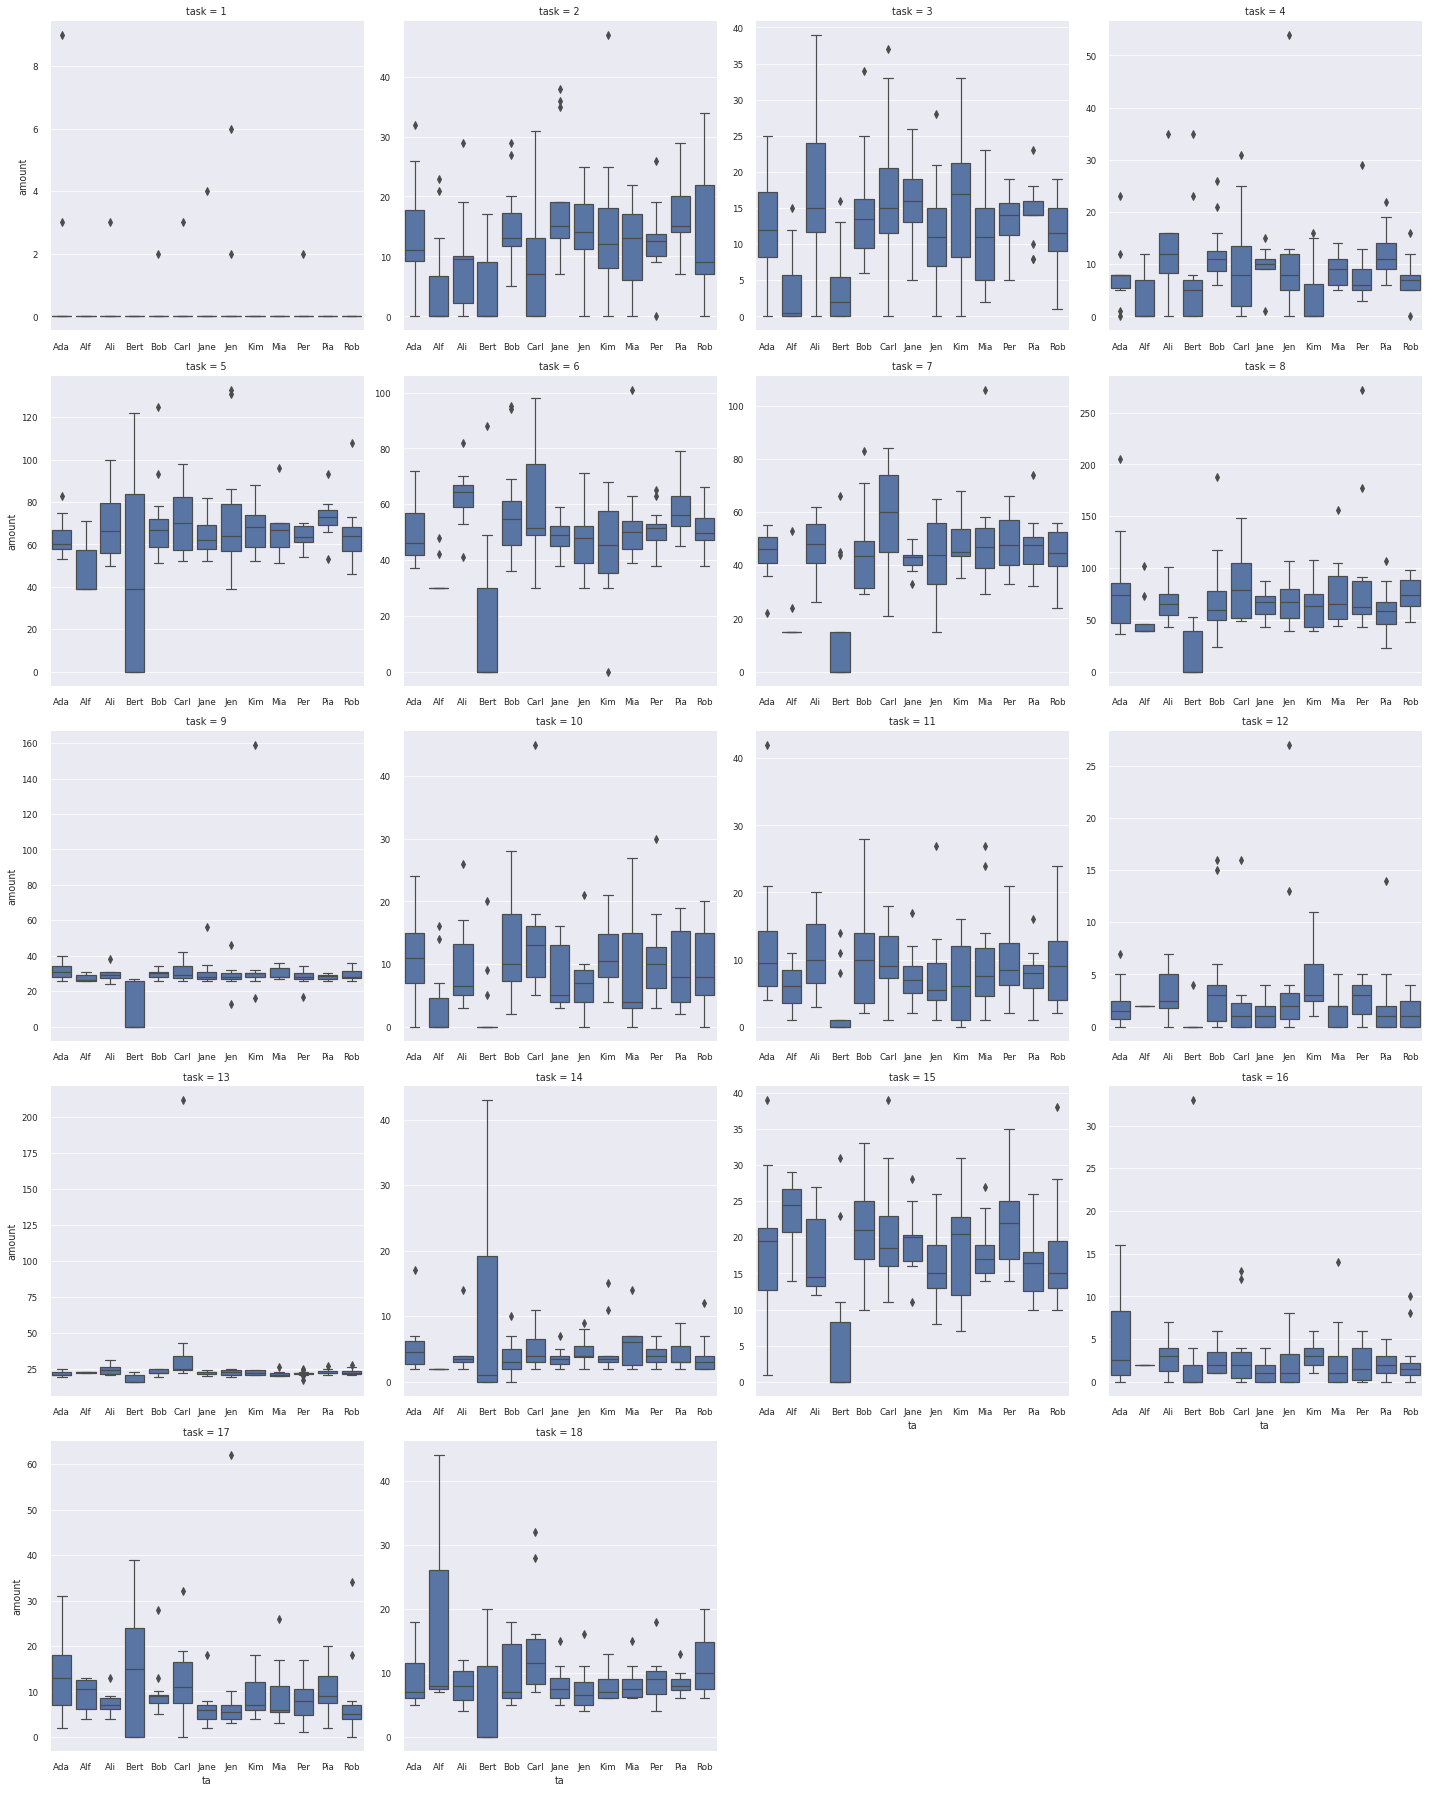

In [18]:
# Compose dataframes
violations = df.groupby(["task", "ta", "student"])["amount"].sum().to_frame().reset_index()
students = df.groupby(["task", "ta"])["student"].nunique().to_frame().reset_index()

g = sn.FacetGrid(violations, col="task", col_wrap=4, height=5, sharey=False, sharex=False)
g.map(sn.boxplot, "ta", "amount")
g.add_legend()

# TODO renskriv
def nobs(df):
    """
    Count the number of observations for a given data frame
    Perhaps should
    """
    df_task = violations.loc[violations["task"] == task]
    sn.boxplot(x = "ta", y = "amount", data = df_task)

    # Retrieve medians for x and y positions to print number of observations
    medians = df_task.groupby(["ta"])["amount"].median()
    nobs = students.loc[students["task"] == task]["student"]
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    pos = range(len(nobs))
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick], 
                medians[tick] + .2, 
                nobs[tick], 
                horizontalalignment="center", 
                size="x-small", 
                color = "black", 
                weight = "semibold"
                )





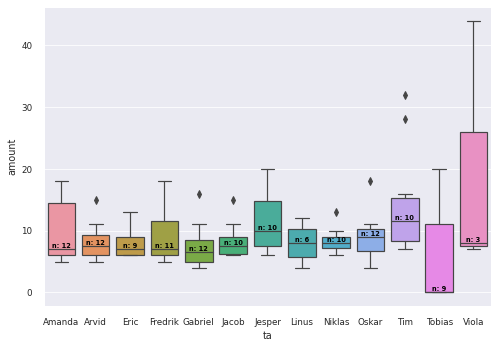

In [19]:

# Read data
df = pd.read_csv("data/processed/student-violations-data.csv")

#for ta, data in df.groupby("ta"):
#    plt.plot(data["amount"], data["violation"])

# Compose dataframes
violations = df.groupby(["task", "ta", "student"])["amount"].sum().to_frame().reset_index()
students = df.groupby(["task", "ta"])["student"].nunique().to_frame().reset_index()


df_task = violations.loc[violations["task"] == 18]
ax = sn.boxplot(x = "ta", y = "amount", data = df_task)

# Retrieve medians for x and y positions to print number of observations
medians = df_task.groupby(["ta"])["amount"].median()
nobs = students.loc[students["task"] == 18]["student"]
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick], 
            medians[tick] + .2, 
            nobs[tick], 
            horizontalalignment="center", 
            size="x-small", 
            color = "black", 
            weight = "semibold"
            )





/tmp/ipykernel_389/3603247580.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(


[task
 1      0.0
 2     -3.5
 3      1.0
 4      3.0
 5      0.5
 6     13.5
 7      2.5
 8      1.0
 9      1.0
 10    -2.5
 11     2.0
 12     0.5
 13     2.0
 14    -0.5
 15    -3.5
 16     1.0
 17     0.0
 18     0.0
 Name: amount, dtype: float64]

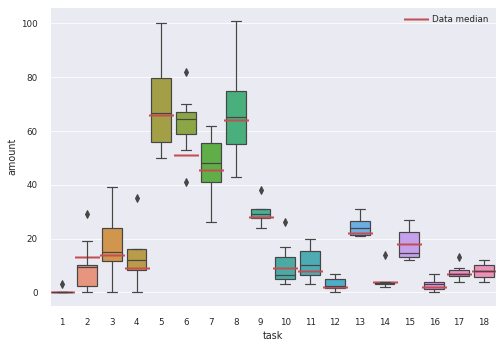

In [20]:
# Plot all task with dataset median for one TA
df = pd.read_csv("data/processed/student-violations-data.csv")

df = df[df["ta"] != "Tobias"]
df = df[df["ta"] != "Viola"]


# for ta, data in df.groupby("ta"):
#    plt.plot(data["amount"], data["violation"])

# Compose dataframes
violations = (
    df.groupby(["task", "ta", "student"])["amount"].sum().to_frame().reset_index()
)
students = df.groupby(["task", "ta"])["student"].nunique().to_frame().reset_index()

# TODO gör detta per ta blir väl en nästlad forloop?
"""
for task, _ in violations.loc[violations["task"]]
    for ta, _ in violations.loc[violations["ta"]]
"""
df_task = violations.loc[violations["task"] == 18]
df_ta = violations.loc[violations["ta"] == "Linus"]


medians = (
    df.groupby(["task", "ta", "student"])["amount"]
    .sum()
    .to_frame()
    .reset_index()
    .groupby(["task"])["amount"]
    .median()
    .to_frame()
    .reset_index()
)

plt.plot(
    medians["amount"],
    "ro",
    label="Data median",
    marker="|",
    markeredgewidth=25,
    markersize=1.5,
)
ax = sn.boxplot(x="task", y="amount", data=df_ta)

plt.legend()

# nu krånglades denna
[
    df_ta.groupby(["task", "ta", "student"])["amount"]
    .sum()
    .to_frame()
    .reset_index()
    .groupby(["task"])["amount"]
    .median()
    - df.groupby(["task", "ta", "student"])["amount"] # minus :) 
    .sum()
    .to_frame()
    .reset_index()
    .groupby(["task"])["amount"]
    .median()
]
# medians["amount"]


In [21]:
df_ta.groupby(["task", "ta","student"])["amount"].sum().to_frame().reset_index().groupby(["task"])["amount"].median()
medians
df.head(15)
repos = df.groupby(["task", "ta", "student"])
repos

In [97]:
df = pd.read_csv("data/processed/student-violations-data.csv")

#df = df.drop(df.loc[df['ta']=="tobias"].index, inplace=True)
df = df[df["ta"] != "Tobias"]
df = df[df["ta"] != "Viola"]

#compose dataframes
violations = df.groupby(["task", "ta", "student"])["amount"].sum().to_frame().reset_index()
students = df.groupby(["task", "ta"])["student"].nunique().to_frame().reset_index()

Dict = {}


for ta in df["ta"].unique():
    df_ta = violations.loc[violations["ta"] == ta]
    medians = (
        df.groupby(["task", "ta", "student"])["amount"]
        .sum()
        .to_frame()
        .reset_index()
        .groupby(["task"])["amount"]
        .median()
        .to_frame()
        .reset_index()
    )

    # The difference between current TA median and the task median over all TA's
    s = pd.DataFrame([
    df_ta.groupby(["task", "ta", "student"])["amount"]
    .sum()
    .to_frame()
    .reset_index()
    .groupby(["task"])["amount"]
    .median()
    - df.groupby(["task", "ta", "student"])["amount"] # minus :) 
    .sum()
    .to_frame()
    .reset_index()
    .groupby(["task"])["amount"]
    .median()
    ])
    
    # Append to dictionary
    Dict[ta] = s
    

dict_keys(['Jacob', 'Eric', 'Arvid', 'Fredrik', 'Amanda', 'Gabriel', 'Jesper', 'Oskar', 'Tim', 'Linus', 'Niklas'])


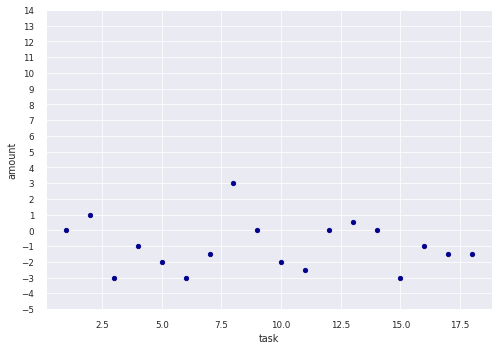

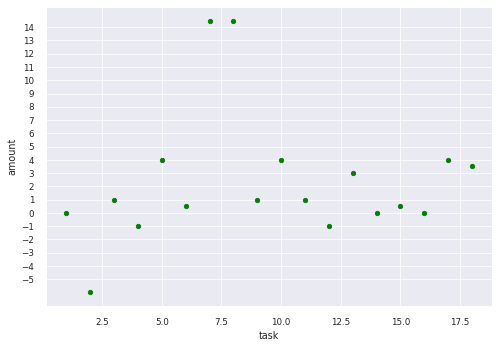

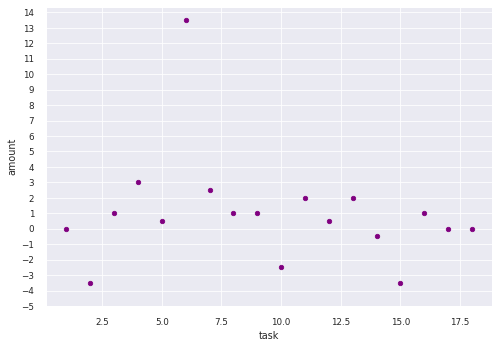

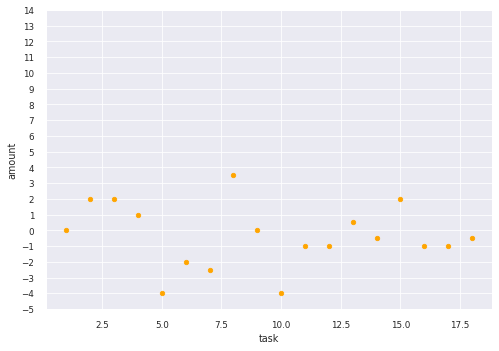

In [103]:
df = Dict["Gabriel"]
df = df.transpose().reset_index()
ax = df.plot.scatter(x='task', y='amount', c='DarkBlue')
plt.yticks(np.arange(-5, 15, 1))

df = Dict["Tim"]
df = df.transpose().reset_index()
df.plot.scatter(x='task', y='amount', c='Green')
plt.yticks(np.arange(-5, 15, 1))

df = Dict["Linus"]
df = df.transpose().reset_index()
df.plot.scatter(x='task', y='amount', c='Purple')
plt.yticks(np.arange(-5, 15, 1))

df = Dict["Arvid"]
df = df.transpose().reset_index()
df.plot.scatter(x='task', y='amount', c='Orange')
plt.yticks(np.arange(-5, 15, 1))

print(Dict.keys())

count    152.000000
mean     351.710526
std      126.178924
min        0.000000
25%      304.000000
50%      361.000000
75%      417.250000
max      775.000000
Name: amount, dtype: float64

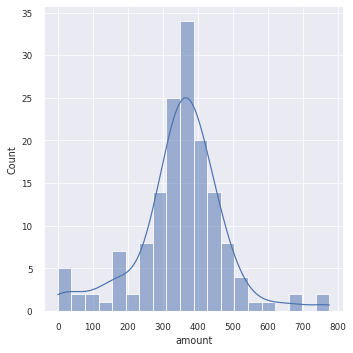

In [137]:
# https://seaborn.pydata.org/tutorial/distributions.html

df = pd.read_csv("data/processed/student-violations-data.csv")

#df = df.drop(df.loc[df['ta']=="tobias"].index, inplace=True)
df = df[df["ta"] != "Tobias"]
df = df[df["ta"] != "Viola"]

dist=df.groupby(["student"])["amount"].sum().sort_values()

g = sn.displot(data=dist,bins=20,kde=True)
#g.plot_marginals(sn.rugplot, color="r", height=-.15, clip_on=False)
#sn.displot(data=dist, kind="ecdf")
dist.describe()
